# Bilinear Optimization: McCormick Envelopes

This notebook demonstrates **automatic linearization of bilinear products** using McCormick envelopes - a fundamental technique for solving nonlinear optimization problems with linear programming solvers.

## Problem Description

**Maximize the area of a rectangle** subject to:
- Minimum perimeter constraint
- Bounds on dimensions

The area formula `Area = length × width` is a **bilinear product** that requires linearization for LP solvers.

## Mathematical Formulation

**Decision Variables:**
$$x \in [x_L, x_U] \quad \text{(length)}$$
$$y \in [y_L, y_U] \quad \text{(width)}$$

**Objective:**
$$\max z = x \times y \quad \text{(bilinear product!)}$$

**Subject to:**
$$2(x + y) \geq \text{MIN\_PERIMETER}$$

## McCormick Envelope Theory

For $z = x \times y$ with $x \in [x_L, x_U]$, $y \in [y_L, y_U]$, the **convex hull** (tightest linear relaxation) is:

$$z \geq x_L y + y_L x - x_L y_L$$
$$z \geq x_U y + y_U x - x_U y_U$$
$$z \leq x_L y + y_U x - x_L y_U$$
$$z \leq x_U y + y_L x - x_U y_L$$

## 1. Setup and Imports

In [1]:
# Standard library
from typing import Any

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# LumiX optimization library
from lumix import (
    LXConstraint,
    LXLinearExpression,
    LXLinearizer,
    LXLinearizerConfig,
    LXModel,
    LXNonLinearExpression,
    LXOptimizer,
    LXVariable,
)
from lumix.solvers import ORTOOLS_CAPABILITIES

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 2. Problem Parameters

In [2]:
# Problem parameters
MIN_PERIMETER = 20.0  # Minimum perimeter (meters)

LENGTH_MIN = 2.0   # Minimum length (meters)
LENGTH_MAX = 10.0  # Maximum length (meters)

WIDTH_MIN = 2.0   # Minimum width (meters)
WIDTH_MAX = 10.0  # Maximum width (meters)

print("Rectangle Optimization Problem")
print("=" * 50)
print(f"Objective: Maximize Area = length × width")
print(f"Constraint: Perimeter ≥ {MIN_PERIMETER}m")
print(f"Length bounds: [{LENGTH_MIN}, {LENGTH_MAX}]m")
print(f"Width bounds: [{WIDTH_MIN}, {WIDTH_MAX}]m")

Rectangle Optimization Problem
Objective: Maximize Area = length × width
Constraint: Perimeter ≥ 20.0m
Length bounds: [2.0, 10.0]m
Width bounds: [2.0, 10.0]m


### Visualize the Bilinear Function

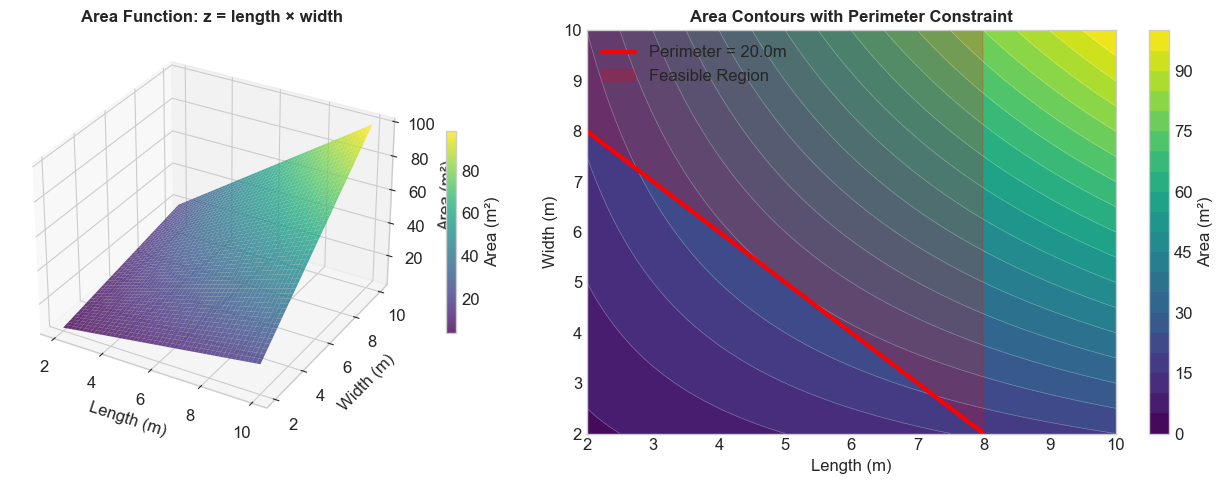

In [3]:
# 3D surface plot of the bilinear function z = x * y
fig = plt.figure(figsize=(14, 5))

# Surface plot
ax1 = fig.add_subplot(121, projection='3d')
x = np.linspace(LENGTH_MIN, LENGTH_MAX, 50)
y = np.linspace(WIDTH_MIN, WIDTH_MAX, 50)
X, Y = np.meshgrid(x, y)
Z = X * Y

surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='none')
ax1.set_xlabel('Length (m)')
ax1.set_ylabel('Width (m)')
ax1.set_zlabel('Area (m²)')
ax1.set_title('Area Function: z = length × width', fontsize=12, fontweight='bold')
fig.colorbar(surf, ax=ax1, shrink=0.5, label='Area (m²)')

# Contour plot with perimeter constraint
ax2 = fig.add_subplot(122)
contour = ax2.contourf(X, Y, Z, levels=20, cmap='viridis')
ax2.contour(X, Y, Z, levels=20, colors='white', alpha=0.3, linewidths=0.5)

# Add perimeter constraint line: 2(x + y) = MIN_PERIMETER
# => y = MIN_PERIMETER/2 - x
x_line = np.linspace(LENGTH_MIN, LENGTH_MAX, 100)
y_line = MIN_PERIMETER/2 - x_line
valid_mask = (y_line >= WIDTH_MIN) & (y_line <= WIDTH_MAX)
ax2.plot(x_line[valid_mask], y_line[valid_mask], 'r-', linewidth=3, label=f'Perimeter = {MIN_PERIMETER}m')
ax2.fill_between(x_line[valid_mask], y_line[valid_mask], WIDTH_MAX, alpha=0.2, color='red', 
                  label='Feasible Region')

ax2.set_xlabel('Length (m)')
ax2.set_ylabel('Width (m)')
ax2.set_title('Area Contours with Perimeter Constraint', fontsize=12, fontweight='bold')
ax2.legend()
fig.colorbar(contour, ax=ax2, label='Area (m²)')

plt.tight_layout()
plt.show()

## 3. Build the Optimization Model

In [4]:
def build_rectangle_model():
    """
    Build rectangle area maximization model with bilinear objective.
    
    The bilinear product (length × width) will be automatically
    linearized using McCormick envelopes.
    """
    # Decision Variables (scalar variables)
    scalar_data = ["dim"]

    length = (
        LXVariable[str, float]("length")
        .continuous()
        .bounds(lower=LENGTH_MIN, upper=LENGTH_MAX)
        .indexed_by(lambda x: x)
        .from_data(scalar_data)
    )

    width = (
        LXVariable[str, float]("width")
        .continuous()
        .bounds(lower=WIDTH_MIN, upper=WIDTH_MAX)
        .indexed_by(lambda x: x)
        .from_data(scalar_data)
    )

    # Create model
    model = LXModel("rectangle_area").add_variables(length, width)

    # Constraint: Minimum perimeter
    model.add_constraint(
        LXConstraint("min_perimeter")
        .expression(
            LXLinearExpression().add_term(length, 2.0).add_term(width, 2.0)
        )
        .ge()
        .rhs(MIN_PERIMETER)
    )

    # Objective: Maximize area = length × width (BILINEAR!)
    area_expr = LXNonLinearExpression().add_product(length, width)
    model.maximize(area_expr)

    return model, length, width


# Build the model
model, length, width = build_rectangle_model()

print("Model Summary:")
print("=" * 50)
print(model.summary())
print("\nNote: Model contains a BILINEAR objective (length × width)")
print("This will be automatically linearized using McCormick envelopes.")

Model Summary:
LXModel: rectangle_area
  Variable Families: 2
  Constraint Families: 1
  Objective: max


Note: Model contains a BILINEAR objective (length × width)
This will be automatically linearized using McCormick envelopes.


## 4. Apply McCormick Linearization

In [5]:
# Create linearizer
config = LXLinearizerConfig(
    mccormick_tighten_bounds=True,
    verbose_logging=True,
)
linearizer = LXLinearizer(model, ORTOOLS_CAPABILITIES, config)

print("Linearizer Configuration:")
print("=" * 50)
print(f"Solver: OR-Tools")
print(f"Needs linearization for bilinear: {ORTOOLS_CAPABILITIES.needs_linearization_for_bilinear()}")

# Check if linearization is needed
if linearizer.needs_linearization():
    print("\nApplying McCormick envelope linearization...")
    linearized_model = linearizer.linearize_model()

    stats = linearizer.get_statistics()
    print("\nLinearization Statistics:")
    print("-" * 50)
    print(f"  Bilinear terms linearized: {stats['bilinear_terms']}")
    print(f"  Auxiliary variables added: {stats['auxiliary_variables']}")
    print(f"  Auxiliary constraints added: {stats['auxiliary_constraints']}")
    
    model_to_solve = linearized_model
else:
    print("\nNo linearization needed.")
    model_to_solve = model

Linearizer Configuration:
Solver: OR-Tools
Needs linearization for bilinear: True

Applying McCormick envelope linearization...

Linearization Statistics:
--------------------------------------------------
  Bilinear terms linearized: 1
  Auxiliary variables added: 1
  Auxiliary constraints added: 4


In [6]:
# Display McCormick envelope constraints
print("\nMcCormick Envelope Constraints:")
print("=" * 50)
print("For z = x × y with bounds:")
print(f"  x ∈ [{LENGTH_MIN}, {LENGTH_MAX}]")
print(f"  y ∈ [{WIDTH_MIN}, {WIDTH_MAX}]")
print("\nThe four envelope constraints are:")
print(f"  z ≥ {LENGTH_MIN}·y + {WIDTH_MIN}·x - {LENGTH_MIN*WIDTH_MIN:.1f}")
print(f"  z ≥ {LENGTH_MAX}·y + {WIDTH_MAX}·x - {LENGTH_MAX*WIDTH_MAX:.1f}")
print(f"  z ≤ {LENGTH_MIN}·y + {WIDTH_MAX}·x - {LENGTH_MIN*WIDTH_MAX:.1f}")
print(f"  z ≤ {LENGTH_MAX}·y + {WIDTH_MIN}·x - {LENGTH_MAX*WIDTH_MIN:.1f}")


McCormick Envelope Constraints:
For z = x × y with bounds:
  x ∈ [2.0, 10.0]
  y ∈ [2.0, 10.0]

The four envelope constraints are:
  z ≥ 2.0·y + 2.0·x - 4.0
  z ≥ 10.0·y + 10.0·x - 100.0
  z ≤ 2.0·y + 10.0·x - 20.0
  z ≤ 10.0·y + 2.0·x - 20.0


## 5. Solve the Model

In [7]:
# Solve
optimizer = LXOptimizer().use_solver("ortools")
print("Solving with OR-Tools...")
solution = optimizer.solve(model_to_solve)

print(f"\nSolution Status: {solution.status}")
print(f"Maximum Area: {solution.objective_value:.4f} m²")
print(f"Solve Time: {solution.solve_time:.3f}s")

2025-12-12 17:03:32 - lumix.optimizer - INFO - Created model 'rectangle_area_linearized' with 3 variables and 5 constraints
2025-12-12 17:03:32 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:03:32 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 16.0000 | Time: 0.00s


Solving with OR-Tools...

Solution Status: optimal
Maximum Area: 16.0000 m²
Solve Time: 0.000s


## 6. Analyze the Results

In [8]:
# Extract solution values
length_val = solution.get_mapped(length)["dim"]
width_val = solution.get_mapped(width)["dim"]
actual_area = length_val * width_val
perimeter = 2 * (length_val + width_val)

print("\n" + "=" * 60)
print("OPTIMAL RECTANGLE")
print("=" * 60)
print(f"Length:    {length_val:.4f} meters")
print(f"Width:     {width_val:.4f} meters")
print(f"Area:      {actual_area:.4f} m²")
print(f"Perimeter: {perimeter:.4f} meters (min required: {MIN_PERIMETER})")

print("\nLinearization Verification:")
print("-" * 60)
print(f"Actual product (length × width): {actual_area:.6f}")
print(f"Objective value from solver:     {solution.objective_value:.6f}")
print(f"Difference:                      {abs(actual_area - solution.objective_value):.8f}")

if abs(actual_area - solution.objective_value) < 1e-4:
    print("\n✓ McCormick envelope linearization is accurate!")
else:
    print("\n⚠ Warning: Linearization may not be exact")


OPTIMAL RECTANGLE
Length:    2.0000 meters
Width:     8.0000 meters
Area:      16.0000 m²
Perimeter: 20.0000 meters (min required: 20.0)

Linearization Verification:
------------------------------------------------------------
Actual product (length × width): 16.000000
Objective value from solver:     16.000000
Difference:                      0.00000000

✓ McCormick envelope linearization is accurate!


## 7. Visualize the Solution

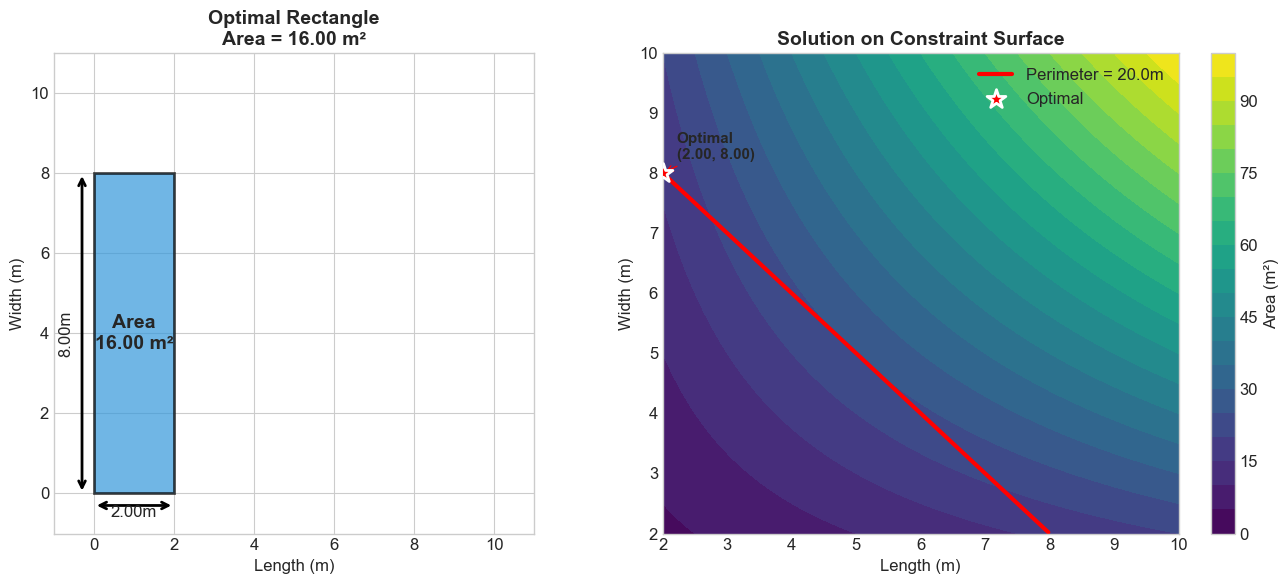

In [9]:
# Solution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Rectangle visualization
ax1 = axes[0]
rect = plt.Rectangle((0, 0), length_val, width_val, fill=True, 
                       facecolor='#3498db', edgecolor='black', linewidth=2, alpha=0.7)
ax1.add_patch(rect)
ax1.set_xlim(-1, LENGTH_MAX + 1)
ax1.set_ylim(-1, WIDTH_MAX + 1)
ax1.set_aspect('equal')
ax1.set_xlabel('Length (m)')
ax1.set_ylabel('Width (m)')
ax1.set_title(f'Optimal Rectangle\nArea = {actual_area:.2f} m²', fontsize=14, fontweight='bold')

# Add dimensions
ax1.annotate('', xy=(length_val, -0.3), xytext=(0, -0.3),
             arrowprops=dict(arrowstyle='<->', color='black', lw=2))
ax1.text(length_val/2, -0.6, f'{length_val:.2f}m', ha='center', fontsize=12)

ax1.annotate('', xy=(-0.3, width_val), xytext=(-0.3, 0),
             arrowprops=dict(arrowstyle='<->', color='black', lw=2))
ax1.text(-0.7, width_val/2, f'{width_val:.2f}m', ha='center', va='center', 
         rotation=90, fontsize=12)

ax1.text(length_val/2, width_val/2, f'Area\n{actual_area:.2f} m²', 
         ha='center', va='center', fontsize=14, fontweight='bold')

# Contour plot with solution
ax2 = axes[1]
x = np.linspace(LENGTH_MIN, LENGTH_MAX, 100)
y = np.linspace(WIDTH_MIN, WIDTH_MAX, 100)
X, Y = np.meshgrid(x, y)
Z = X * Y

contour = ax2.contourf(X, Y, Z, levels=20, cmap='viridis')

# Perimeter constraint line
x_line = np.linspace(LENGTH_MIN, LENGTH_MAX, 100)
y_line = MIN_PERIMETER/2 - x_line
valid_mask = (y_line >= WIDTH_MIN) & (y_line <= WIDTH_MAX)
ax2.plot(x_line[valid_mask], y_line[valid_mask], 'r-', linewidth=3, 
         label=f'Perimeter = {MIN_PERIMETER}m')

# Optimal point
ax2.scatter([length_val], [width_val], c='red', s=200, marker='*', 
            edgecolors='white', linewidth=2, zorder=5, label='Optimal')
ax2.annotate(f'Optimal\n({length_val:.2f}, {width_val:.2f})', 
             (length_val, width_val), textcoords='offset points', 
             xytext=(10, 10), fontsize=11, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='red'))

ax2.set_xlabel('Length (m)')
ax2.set_ylabel('Width (m)')
ax2.set_title('Solution on Constraint Surface', fontsize=14, fontweight='bold')
ax2.legend()
fig.colorbar(contour, ax=ax2, label='Area (m²)')

plt.tight_layout()
plt.show()

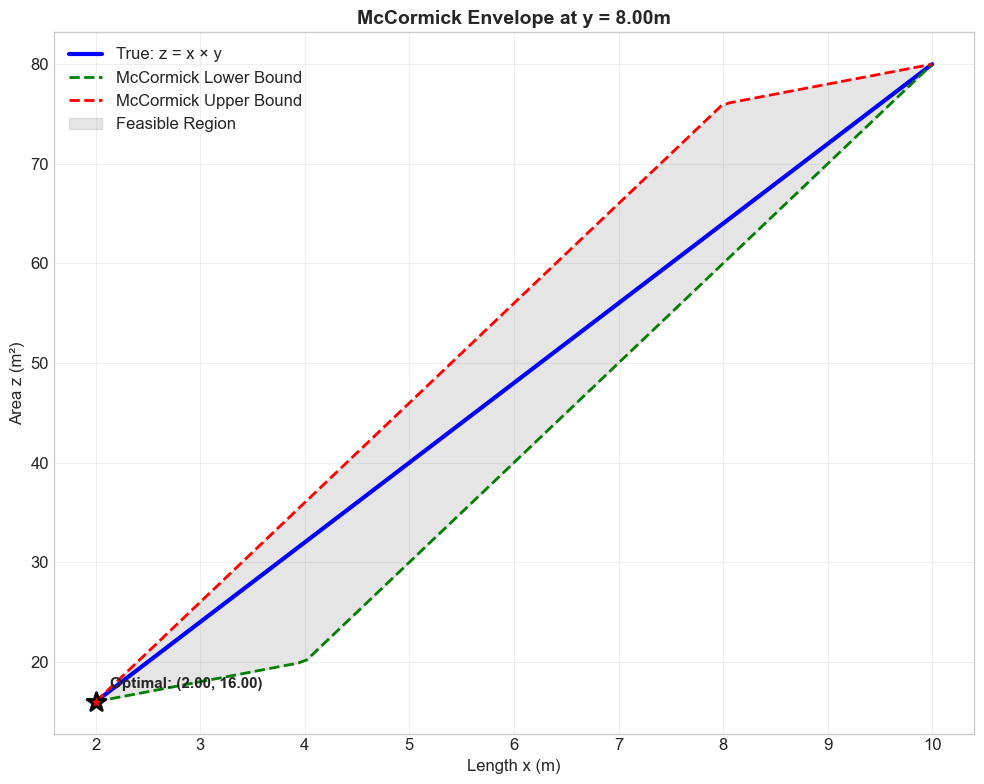

In [10]:
# McCormick envelope visualization
fig, ax = plt.subplots(figsize=(10, 8))

# For a fixed y value, show how z varies with x
y_fixed = width_val
x_range = np.linspace(LENGTH_MIN, LENGTH_MAX, 100)

# True bilinear product
z_true = x_range * y_fixed

# McCormick bounds (for fixed y)
# Lower bound: z >= xL*y + yL*x - xL*yL
z_lower1 = LENGTH_MIN * y_fixed + WIDTH_MIN * x_range - LENGTH_MIN * WIDTH_MIN
z_lower2 = LENGTH_MAX * y_fixed + WIDTH_MAX * x_range - LENGTH_MAX * WIDTH_MAX
z_lower = np.maximum(z_lower1, z_lower2)

# Upper bound: z <= xL*y + yU*x - xL*yU
z_upper1 = LENGTH_MIN * y_fixed + WIDTH_MAX * x_range - LENGTH_MIN * WIDTH_MAX
z_upper2 = LENGTH_MAX * y_fixed + WIDTH_MIN * x_range - LENGTH_MAX * WIDTH_MIN
z_upper = np.minimum(z_upper1, z_upper2)

ax.plot(x_range, z_true, 'b-', linewidth=3, label='True: z = x × y')
ax.plot(x_range, z_lower, 'g--', linewidth=2, label='McCormick Lower Bound')
ax.plot(x_range, z_upper, 'r--', linewidth=2, label='McCormick Upper Bound')
ax.fill_between(x_range, z_lower, z_upper, alpha=0.2, color='gray', 
                 label='Feasible Region')

# Optimal point
ax.scatter([length_val], [actual_area], c='red', s=200, marker='*', 
           edgecolors='black', linewidth=2, zorder=5)
ax.annotate(f'Optimal: ({length_val:.2f}, {actual_area:.2f})', 
            (length_val, actual_area), textcoords='offset points', 
            xytext=(10, 10), fontsize=11, fontweight='bold')

ax.set_xlabel('Length x (m)')
ax.set_ylabel('Area z (m²)')
ax.set_title(f'McCormick Envelope at y = {y_fixed:.2f}m', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Key Insights

### What We Learned

1. **Bilinear Products**: When you have `z = x × y` where both x and y are decision variables, LP solvers can't handle this directly.

2. **McCormick Envelopes**: Create the tightest possible linear relaxation (convex hull) for bilinear terms using four linear constraints.

3. **Automatic Linearization**: LumiX's `LXLinearizer` automatically detects and linearizes bilinear products.

4. **Bound Importance**: Tighter variable bounds → better approximation quality.

### When to Use

- Area/volume optimization
- Pooling and blending problems
- Bilinear cost functions
- Any problem where two decision variables are multiplied

## 9. Extensions & Exercises

1. **Tighter bounds**: How does the solution change with tighter bounds?
2. **Multiple products**: Add a third dimension (box volume = l × w × h)
3. **Compare solvers**: Try Gurobi/CPLEX which have native QP support
4. **Bound tightening**: Experiment with McCormick bound tightening